### $\Lambda$-CDM model 

\begin{equation}
H(z) = H_0 \sqrt{\Omega_{m,0}(1+z)^2 + \frac{\Lambda}{3H_0^2}}
\end{equation}

when $z=0$, $\Lambda = 3H_0^2(1-\Omega_{m,0})$


\begin{equation}
\frac{dx}{dz} = \frac{3x}{1+z}
\end{equation}

with $$x_0 = \Omega_{m,0} = \frac{\kappa_0 \rho_{m,0}}{3 H_0^2}$$

Then

\begin{equation}
H(z) = H_0 \sqrt{x(z) + 1 - \Omega_{m,0}}
\end{equation}

In [135]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import mplcyberpunk
import tqdm
from functions import nth_derivative#, Param_dirich
plt.style.use('cyberpunk')

#### There are two methods within the PINN paradigm: 

#### 1. To meet the bpundary and initial conditions by a reparametrization of the ANN

Here we have an initial value problem. Then we can reparametrize the solution as:

$$ANN(z,x_0) ---> Param(x,x_0) $$



$$Param(z,x_0) = x_0 + (1-e^{-(z-z_0)})ANN(z)$$

In [136]:
#Domain intervals

zi=0.0
zf=3.0
#t=torch.linspace(zi,zf,150).view(-1,1)
x0_i=0.2
x0_f=0.5

T=torch.cartesian_prod(torch.linspace(zi,zf,100),
                       torch.linspace(x0_i,x0_f,40))

#random permutation of the training dataset T
T=T[torch.randperm(T.shape[0])]

In [137]:
if torch.cuda.is_available(): T.cuda()

In [138]:
T.shape

torch.Size([4000, 2])

In [139]:
#Neural network architecture

nodos=20
ANN = nn.Sequential(nn.Linear(2, nodos), nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    # nn.Tanh(), nn.Linear(nodos,nodos)
                    nn.Tanh(),nn.Linear(nodos,1))
print(ANN)

Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Tanh()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Tanh()
  (4): Linear(in_features=20, out_features=1, bias=True)
)


In [140]:
#Re-parametrization

def Param(T,net=ANN,ti=zi):
    out = net(T)
    b=1-torch.exp(ti-T[:,0])
    return T[:,1].view(-1,1) +b.view(-1,1)*out

In [141]:
def cost(t):
    x=Param(t)
    z=t[:,0].view(-1,1)
    Dx = nth_derivative(Param,t,0,0,1)
    osc = Dx - (3*x / (1.0+z))

    return torch.mean(osc**2)

In [142]:
cost(T)

tensor(0.2417, grad_fn=<MeanBackward0>)

In [143]:
# #4 Error and optimizer
# learning_rate=0.01
# epocas=400

# #optimizer=torch.optim.SGD(ANN.parameters(),lr=learning_rate,momentum=0.9)
# optimizer = torch.optim.Adam(ANN.parameters(), lr=learning_rate)
# #optimizer = torch.optim.Adadelta(ANN.parameters(), lr=learning_rate)

Training: 100%|████████████████████████████████| 30000/30000 [04:30<00:00, 110.79it/s, loss=4.36e-6]


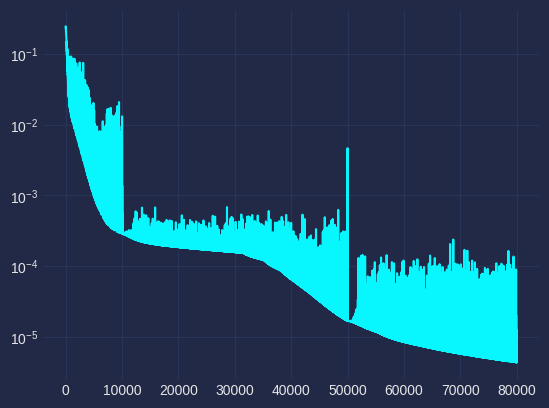

In [144]:
#training loop
#pbar = tqdm.tqdm(range(epocas), desc="Training",  colour='cyan', ncols=100)
epochs=[10000,40000,30000]
tasas=[0.01,0.001,0.0005]
errores=[]
for k in range(len(epochs)):
    learning_rate=tasas[k]
    epocas=epochs[k]

    #optimizer=torch.optim.SGD(ANN.parameters(),lr=learning_rate,momentum=0.9)
    optimizer = torch.optim.Adam(ANN.parameters(), lr=learning_rate)
    pbar = tqdm.tqdm(range(epocas), desc="Training",  colour='cyan', ncols=100)
    for i in pbar:
        l=cost(T) #coste
        l.backward() #gradiente
        optimizer.step() #se actualizan los parámetros
        optimizer.zero_grad() #vacíamos el gradiente
        errores.append(float(l))
        pbar.set_postfix({'loss': l.item()})

plt.plot(range(np.sum(epochs)),errores)
plt.yscale('log')

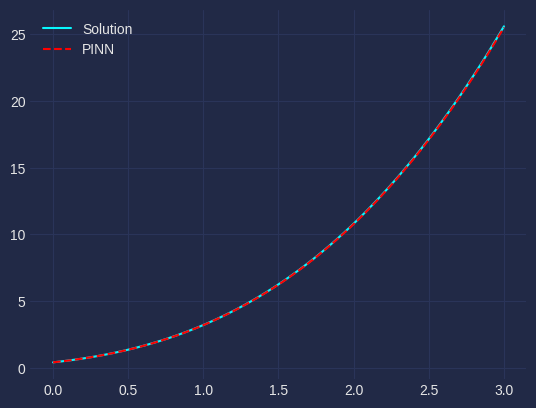

In [145]:
pos_ini=0.4

z0 = torch.linspace(zi,zf,60)
x0 = pos_ini*torch.ones([z0.shape[0],1])
#v0 = vel_ini*torch.ones([t0.shape[0],1])
# delta0 = d*torch.ones([t0.shape[0],1])
# omega0 = omega*torch.ones([t0.shape[0],1])

X=torch.cat((z0.view(-1,1),x0),1)
#X.cuda()
#plt.plot(t0, -torch.sin(t0)+2*t0+pos_ini, label='solución real')
#plt.plot(z0.detach(), sol_x([pos_ini,vel_ini], t0, d, omega), label='solución real')
plt.plot(z0,pos_ini * (z0+1)**3, label='Solution')
plt.plot(z0,Param(X).detach().numpy(),'--r', label='PINN')

#plt.plot(t0.view(-1,1),Param(t0.view(-1,1)).detach().numpy(),'--r', label='PINN')
plt.legend()

In [146]:
%timeit Param(X).detach().numpy()

182 µs ± 3.51 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [147]:
#%timeit sol_x([pos_ini,vel_ini], t0, d, omega) #odeint

In [148]:
torch.save(ANN.state_dict(),'L-CDM_param_dict_copy')

---
### For evaluating the model, and perform a benchmarking we use:

In [149]:
nodos=20
ANN_param = nn.Sequential(nn.Linear(2, nodos), nn.Tanh(),
                           nn.Linear(nodos,nodos),
                    nn.Tanh(),nn.Linear(nodos,1))
print(ANN_param)

Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Tanh()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Tanh()
  (4): Linear(in_features=20, out_features=1, bias=True)
)


In [150]:
ANN_param.load_state_dict(torch.load('L-CDM_param_dict_copy'))
ANN_param.eval()

Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Tanh()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Tanh()
  (4): Linear(in_features=20, out_features=1, bias=True)
)

In [151]:
z_mesh = np.linspace(zi, zf, 100)
x0_mesh = np.linspace(x0_i, x0_f, 100)

z_param = torch.linspace(zi, zf, 100)
x0_param = torch.linspace(x0_i, x0_f, 100)

mesh=np.ones((100,100))

In [152]:
for i in range(100):
    for j in range(100):
        a=Param(torch.tensor([[z_param[i],x0_param[j]]]), net=ANN_param).detach().numpy()
        #b=sol_x([x0_mesh[j],1.0], [z_mesh[i]], 1.5, 3.0)
        b=x0_mesh[j] * (z_mesh[i]+1)**3
        
        mesh[i,j] =  abs(a-b)/abs(b) * 100.0

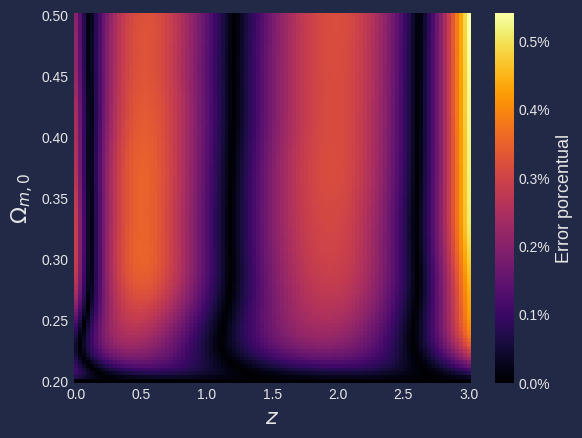

In [153]:
fig, ax = plt.subplots()

# Creamos la barra de densidad
pcolormesh = ax.pcolormesh(z_mesh, x0_mesh, mesh, cmap='inferno')

# Modificamos la función `colorbar` para que muestre el símbolo de porcentaje
colorbar = plt.colorbar(pcolormesh, format='%1.1f%%')
colorbar.ax.set_ylabel('Error porcentual', size=13)
ax.set_xlabel('$z$', size=16)
ax.set_ylabel('$\Omega_{m,0}$', size=16)
# Mostramos la gráfica
plt.show()
#plt.savefig()
#fig.savefig('L-CDM.pdf')